In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import sys
import os
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *

# %matplotlib widget
# import ipywidgets as widgets

In [2]:
_parent_folder = "omni_sensor_feb_14_2023"
_folder_name = "sk24_00_rotation_slow"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\simulation\\..\\recording_programs\\test_data\\omni_sensor_feb_14_2023'

In [3]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# rename columns
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)
_sk_df["e_t"] =  -_sk_df["e_t"]
_sk_df["e_rr"] = -_sk_df["e_rr"]
_sk_df["e_rl"] = _sk_df["e_rl"]

In [4]:
y = (19.5/2)/100 # meters
x = 7.5/100 # meters
radius = 5.5/200 # meters

df = _sk_df.copy()
df = set_zero(df)
df, ang_col = get_angular_velocity(df, ang_per_increment=0.0894, del_t=0.01)
df, vel_col = get_directional_velocity(df, ang_col, radius=radius, x = x, y = y)
df, col_names = get_position(df)
df, _ang_name = get_orientation(df)


In [5]:
# mocap data
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

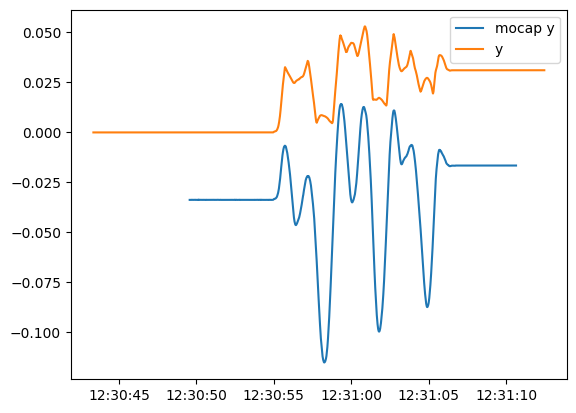

In [6]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df.time, _mocap_df.m2_z + 0.25, label="mocap y")
plt.plot(df.time, df["y_val"], label="y")

# plt.plot(df["w"], label="theta")
plt.legend()

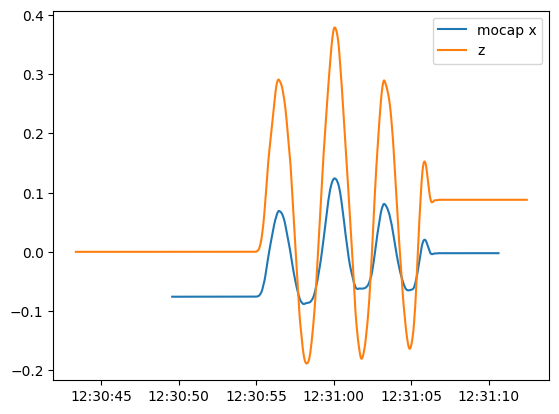

In [7]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df.time, _mocap_df.m2_x - 0.3, label="mocap x")
plt.plot(df.time, df["x_val"], label="z")

# plt.plot(df["w"], label="theta")
plt.legend()

In [8]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df.m4_x.iloc[0], _mocap_df.m4_y.iloc[0], _mocap_df.m4_z.iloc[0]]
xvec = np.array(xvec).reshape(3,1)

yvec = [_mocap_df.m3_x.iloc[0], _mocap_df.m3_y.iloc[0], _mocap_df.m3_z.iloc[0]]
yvec = np.array(yvec).reshape(3,1)

org = [_mocap_df.m2_x.iloc[0], _mocap_df.m2_y.iloc[0], _mocap_df.m2_z.iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = yvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vycap = v2 - (vxnorm.T @ v2) * vxnorm
vynorm = vycap / np.linalg.norm(vycap)

vznorm = np.cross(vynorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [9]:
_mc_df = _mocap_df[["time", "m2_x", "m2_y", "m2_z"]].copy()
_mc_df = _mc_df.rename(columns={"m2_x": "x", "m2_y": "y", "m2_z": "z"})

# apply rotation matrix
for i in range(len(_mc_df)):
    _mc_df.iloc[i, 1:] = (rotMat.T @ (_mc_df.iloc[i, 1:].values.reshape(3,1) - org)).T[0]


In [10]:
# rotate along y axis
# _mc_df["x"] = _mc_df["x"] * np.cos(np.deg2rad(90)) - _mc_df["z"] * np.sin(np.deg2rad(90))

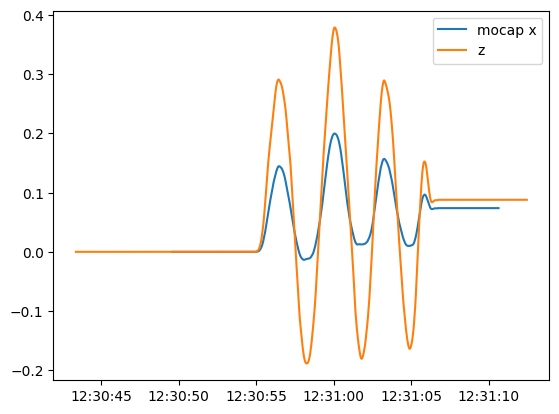

In [11]:
plt.plot(_mocap_df.time, -_mc_df.x, label="mocap x")
plt.plot(df.time, df["x_val"], label="z")

# plt.plot(df["w"], label="theta")
plt.legend()

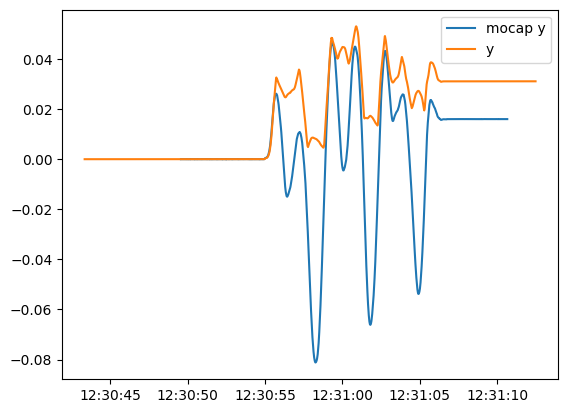

In [12]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df.time, _mc_df.y, label="mocap y")
plt.plot(df.time, df["y_val"], label="y")

# plt.plot(df["w"], label="theta")
plt.legend()

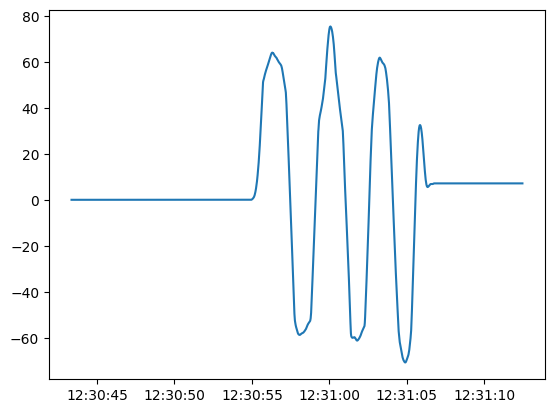

In [13]:
plt.plot(df.time, np.rad2deg(df["theta"]), label="y")


In [14]:
# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_rotmat_i = []
for i in range(len(_m_df)):
    _x_vec = _m_df[["m4_x", "m4_y", "m4_z"]].loc[i].values
    _x_vec = np.reshape(_x_vec, (3,1))
    _org = _m_df[["m2_x", "m2_y", "m2_z"]].loc[i].values
    _org = np.reshape(_org, (3,1))
    _y_vec = _m_df[["m3_x", "m3_y", "m3_z"]].loc[i].values
    _y_vec = np.reshape(_y_vec, (3,1))
    _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in range(len(_rotmat_i)):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in _del_r:
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

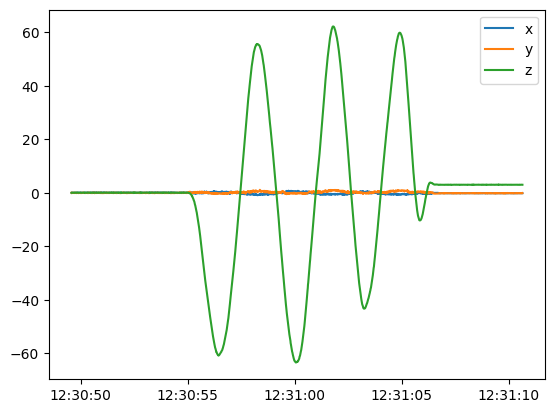

In [15]:
# plt.plot(df.time, np.rad2deg(df["theta"]), label="y")
plt.plot(_m_df.time, _theta_x, label="x")
plt.plot(_m_df.time, _theta_y, label="y")
plt.plot(_m_df.time, _theta_z, label="z")
plt.legend()


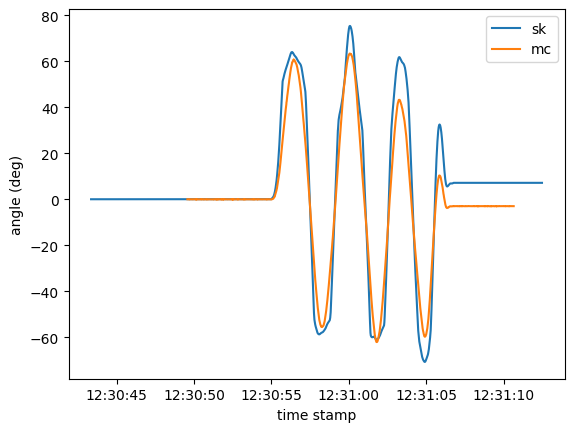

In [18]:
plt.plot(df.time, np.rad2deg(df["theta"]), label="sk")
plt.plot(_m_df.time, -_theta_z, label="mc")
plt.ylabel("angle (deg)")
plt.xlabel("time stamp")
plt.legend()